# Analysis & Comparison 

## Libraries 

In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

## Data set 

In [2]:
#file = 'Data/data.csv'
file = 'Data/new_dataset_clean.csv'
dataframe = pd.read_csv(file, error_bad_lines=False, sep=";")
df = dataframe.copy()
print("Data set's shape = ", df.shape) 
print("There is {} missing values in the target".format(df['Label'].isnull().sum()))

Data set's shape =  (43721, 2)
There is 0 missing values in the target


In [35]:
df.tail(7)

,Tweets,Label
43714,you're all niggers,1
43715,you're such a retard i hope you get type 2 dia...,1
43716,you's a muthaf***in lie right his tl is tr...,1
43717,you've gone and broke the wrong hea baby and ...,0
43718,young buck wanna eat dat nigguh like i aint fu...,1
43719,youu got wild bitches tellin you lies,1
43720,ruffled ntac eileen dahlia beautiful color c...,0


**Number of Tokens per canonization method** 

In [13]:
from DPreprocessing import canonization
nbr_lemmatized_tokens = len(canonization(df['Tweets'], method="lemmatization"))
nbr_stemmed_tokens = len(canonization(df['Tweets'], method="stemming"))

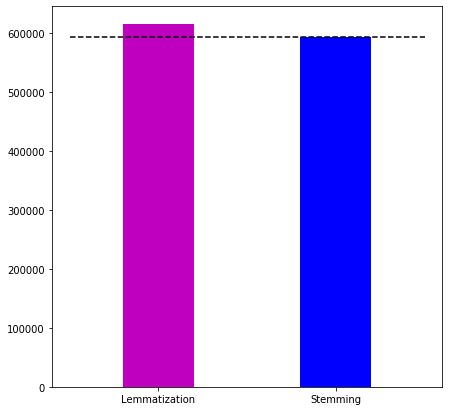

In [34]:
import matplotlib.pyplot as plt 
plt.figure(figsize=(7,7))
methods = ["Lemmatization","Stemming"]
nbr_tokens = [nbr_lemmatized_tokens, nbr_stemmed_tokens]
plt.bar(methods, nbr_tokens, width=0.4, align='center', color=['m','b'])
plt.hlines(nbr_tokens[1], -0.5, 1.5, colors='k', linestyles='dashed')
plt.show()